## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder



## Načítanie dát

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_cnt.csv')

## Rozdelenie dát

In [ ]:
labels = dataset['author_id'].unique()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
index_to_id_mapping = {index: author_id for index, author_id in enumerate(one_hot_encoder.categories_[0])}
index_to_id_mapping

{0: 17,
 1: 45,
 2: 65,
 3: 69,
 4: 120,
 5: 204,
 6: 213,
 7: 410,
 8: 505,
 9: 585,
 10: 594,
 11: 791,
 12: 1060,
 13: 1181,
 14: 1230,
 15: 1626,
 16: 1758,
 17: 3141,
 18: 5166,
 19: 8137}

## TextVectorization

In [ ]:
embedding_dim = 256
vocab_size = 70000
sequence_length = 8000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

### Model 1 - LSTM+GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 8000, 256)         17920000  
                                                                 
 lstm (LSTM)                 (None, 8000, 256)         525312    
                                                                 
 dropout (Dropout)           (None, 8000, 256)         0         
                                                                 
 gru (GRU)                   (None, 8000, 128)         148224    
                                                             

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback, stop])

Epoch 1/10
74/74 [==============================] - 71s 855ms/step - loss: 3.2738 - accuracy: 0.1297 - val_loss: 2.7169 - val_accuracy: 0.1818
Epoch 2/10
74/74 [==============================] - 54s 729ms/step - loss: 2.3564 - accuracy: 0.2543 - val_loss: 2.3326 - val_accuracy: 0.3182
Epoch 3/10
74/74 [==============================] - 52s 699ms/step - loss: 2.0860 - accuracy: 0.3857 - val_loss: 2.2262 - val_accuracy: 0.3788
Epoch 4/10
74/74 [==============================] - 52s 700ms/step - loss: 1.7321 - accuracy: 0.4232 - val_loss: 1.9265 - val_accuracy: 0.4091
Epoch 5/10
74/74 [==============================] - 47s 628ms/step - loss: 1.3068 - accuracy: 0.5904 - val_loss: 2.0269 - val_accuracy: 0.3485
Epoch 6/10
74/74 [==============================] - 46s 621ms/step - loss: 1.3793 - accuracy: 0.5768 - val_loss: 2.2300 - val_accuracy: 0.2879
Epoch 7/10
74/74 [==============================] - 47s 636ms/step - loss: 1.1424 - accuracy: 0.6416 - val_loss: 4.2321 - val_accuracy: 0.3788

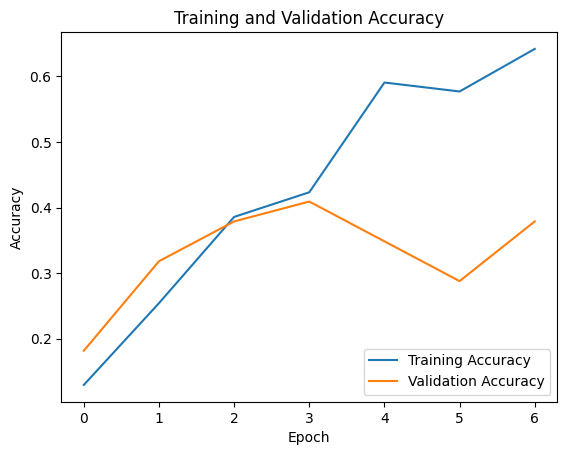

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 3s 325ms/step
[ 3 16 15 11  6 15  3  4  4  6 12 17  9 15  5  7  1 14 13  6  8 12 11 15
 10 10  6  3  3 12  4 11  2  2 17 10  3 13 12  1 12  6 13  8 11  3  6  5
  6  9 19 15 17 17  7  1  4 12  1 17 19 19  8 18  3  3 19 10 14  8 16 13
  3 15 10 10 19 16  1 19  3 15 13 12 12 15  6  3  5 19  6  4  6  5  4 18
 13  9 19  3  6 10 15  2  2  5 14 13 12  5  6 15  5  6 13  6 12 10 17 14
 15 13  3 19 13  2  8 17  2 10 13 17  4 16 12 16 15 13 17 13  9 13  4 18
  4 19 10 17 14  9 19  7  1 10 19  2 13 15 15 13 15 17  9 17]


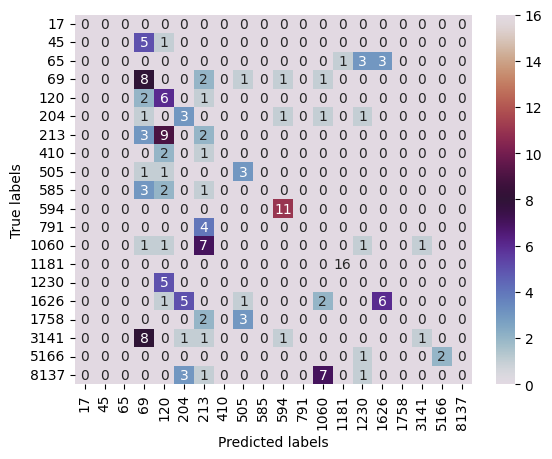

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print(y_true)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.35365853658536583
F1 Score: 0.307465564326925
Precision: 0.3218169473998025
Recall: 0.35365853658536583


### Model 2 - BIDIRECTIONAL LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 8000, 256)         17920000  
                                                                 
 bidirectional (Bidirection  (None, 8000, 256)         394240    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=12, batch_size=8)

Epoch 1/12
74/74 [==============================] - 53s 643ms/step - loss: 2.7861 - accuracy: 0.1297 - val_loss: 2.5421 - val_accuracy: 0.1667
Epoch 2/12
74/74 [==============================] - 45s 603ms/step - loss: 2.1929 - accuracy: 0.2969 - val_loss: 2.0123 - val_accuracy: 0.2727
Epoch 3/12
74/74 [==============================] - 46s 620ms/step - loss: 1.8261 - accuracy: 0.3703 - val_loss: 1.8118 - val_accuracy: 0.3182
Epoch 4/12
74/74 [==============================] - 45s 614ms/step - loss: 1.4733 - accuracy: 0.4471 - val_loss: 1.6396 - val_accuracy: 0.3485
Epoch 5/12
74/74 [==============================] - 45s 611ms/step - loss: 1.2161 - accuracy: 0.5597 - val_loss: 1.5422 - val_accuracy: 0.5000
Epoch 6/12
74/74 [==============================] - 48s 643ms/step - loss: 0.9957 - accuracy: 0.6348 - val_loss: 1.2565 - val_accuracy: 0.5909
Epoch 7/12
74/74 [==============================] - 46s 617ms/step - loss: 0.8782 - accuracy: 0.7082 - val_loss: 1.2273 - val_accuracy: 0.5758

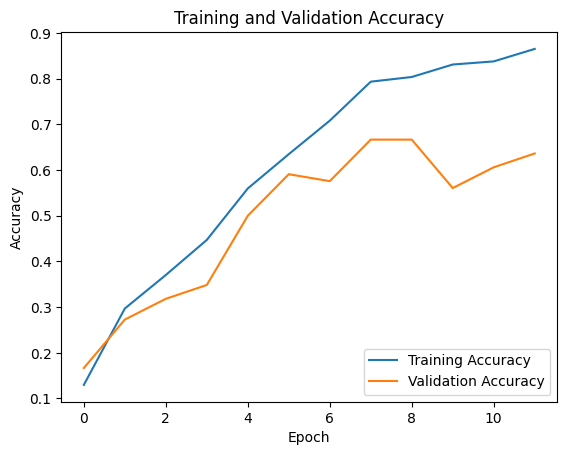

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 2s 231ms/step
[ 3 16 15 11  6 15  3  4  4  6 12 17  9 15  5  7  1 14 13  6  8 12 11 15
 10 10  6  3  3 12  4 11  2  2 17 10  3 13 12  1 12  6 13  8 11  3  6  5
  6  9 19 15 17 17  7  1  4 12  1 17 19 19  8 18  3  3 19 10 14  8 16 13
  3 15 10 10 19 16  1 19  3 15 13 12 12 15  6  3  5 19  6  4  6  5  4 18
 13  9 19  3  6 10 15  2  2  5 14 13 12  5  6 15  5  6 13  6 12 10 17 14
 15 13  3 19 13  2  8 17  2 10 13 17  4 16 12 16 15 13 17 13  9 13  4 18
  4 19 10 17 14  9 19  7  1 10 19  2 13 15 15 13 15 17  9 17]


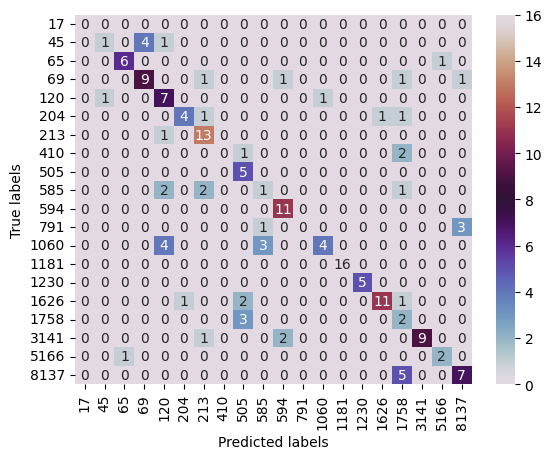

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print(y_true)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6890243902439024
F1 Score: 0.677505921967746
Precision: 0.7072090849529874
Recall: 0.6890243902439024


### Model 3 - LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(128, return_sequences=True)(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(64)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 8000, 256)         17920000  
                                                                 
 lstm_2 (LSTM)               (None, 8000, 128)         197120    
                                                                 
 dropout_5 (Dropout)         (None, 8000, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
74/74 [==============================] - 47s 577ms/step - loss: 2.9185 - accuracy: 0.0887 - val_loss: 2.9333 - val_accuracy: 0.1212
Epoch 2/10
74/74 [==============================] - 42s 562ms/step - loss: 2.7458 - accuracy: 0.1451 - val_loss: 2.9035 - val_accuracy: 0.1212
Epoch 3/10
74/74 [==============================] - 42s 569ms/step - loss: 2.6163 - accuracy: 0.1621 - val_loss: 2.8773 - val_accuracy: 0.1212
Epoch 4/10
74/74 [==============================] - 40s 542ms/step - loss: 2.4414 - accuracy: 0.2031 - val_loss: 2.9059 - val_accuracy: 0.1515
Epoch 5/10
74/74 [==============================] - 41s 554ms/step - loss: 2.2202 - accuracy: 0.2884 - val_loss: 2.9997 - val_accuracy: 0.1364
Epoch 6/10
74/74 [==============================] - 41s 554ms/step - loss: 2.0943 - accuracy: 0.3430 - val_loss: 3.0462 - val_accuracy: 0.1364


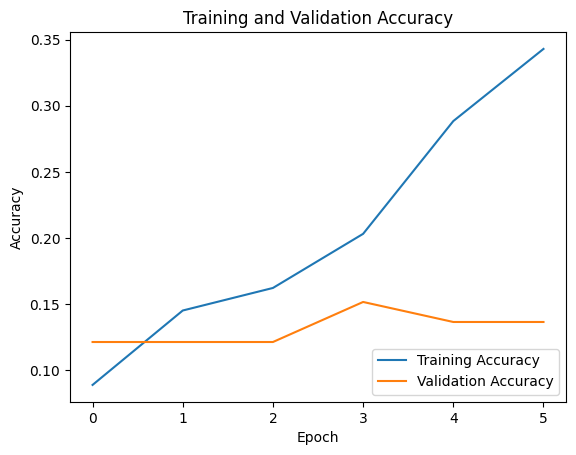

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 2s 206ms/step
[ 3 16 15 11  6 15  3  4  4  6 12 17  9 15  5  7  1 14 13  6  8 12 11 15
 10 10  6  3  3 12  4 11  2  2 17 10  3 13 12  1 12  6 13  8 11  3  6  5
  6  9 19 15 17 17  7  1  4 12  1 17 19 19  8 18  3  3 19 10 14  8 16 13
  3 15 10 10 19 16  1 19  3 15 13 12 12 15  6  3  5 19  6  4  6  5  4 18
 13  9 19  3  6 10 15  2  2  5 14 13 12  5  6 15  5  6 13  6 12 10 17 14
 15 13  3 19 13  2  8 17  2 10 13 17  4 16 12 16 15 13 17 13  9 13  4 18
  4 19 10 17 14  9 19  7  1 10 19  2 13 15 15 13 15 17  9 17]


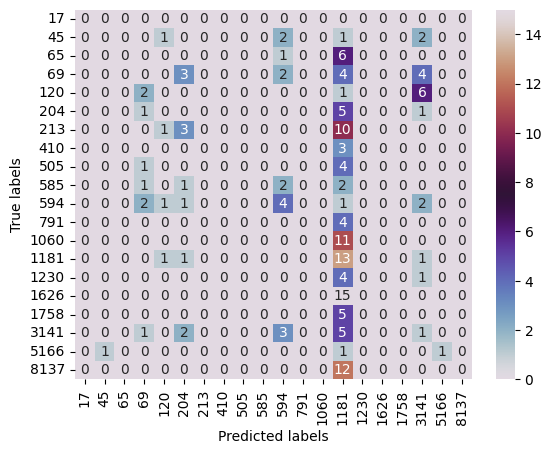

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print(y_true)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.11585365853658537
F1 Score: 0.056110450128891536
Precision: 0.05337468928761383
Recall: 0.11585365853658537
